In [1]:
%reset -f
%matplotlib inline

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
dirToInclude=parentdir +'/features/'
sys.path.insert(0,dirToInclude)


import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import scipy as sp
import theano.tensor as t

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Read in Stata datafile
#data_stata = pd.io.stata.read_stata('../ProjectDef/cnsfinall2.dta')
#Convert to .csv. Now you never need to do this again
#data_stata.to_csv('../Data/cns_data.csv')

In [3]:
data = pd.read_csv("../Data/cns_data.csv")
rf_results = pd.read_csv("Outputs/rf_results.csv")

In [4]:
#Adding a variable that is just 'month and day' - seems better to capture seasonality.
data['month'] = pd.DatetimeIndex(data['incdate']).month
data['day'] = pd.DatetimeIndex(data['incdate']).day
data['monthday'] = data['month']*30+data['day']

In [5]:
var = data.loc[:,['glasgtot','blanttot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinearinf','clinanemia','clintonsil','clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','head','muscle','conv',\
                         'sex','ageyrs','agemth','incdate',\
                         'temp','card','resp','sbp','dbp','weight','height','muac',\
                          'mhhosp', 'mhdevsp', 'mhsickle', 'mhchronstat',\
                         'monthday','dimain', \
                         'incirrit', 'inchead', 'incphoto',\
                         'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                          'incpurp','diag']] #This is the final diagnosis - will be the 'label'


In [6]:
#Convert the date into a useful value. This just counts the days from the beginning of the dataset 
var['incdate'] = pd.to_datetime(var['incdate'])
var['date'] = (var['incdate'] - var['incdate'].min())  / np.timedelta64(1,'D')

#Mapping yes/no to 1/0
var['clinjaund'] = var.clinjaund.map({'Yes': 1, 'No': 0})
var['clinhepato'] = var.clinhepato.map({'Yes': 1, 'No': 0})
var['clinspleno'] = var.clinspleno.map({'Yes': 1, 'No': 0})
var['clinconv'] = var.clinconv.map({'Yes': 1, 'No': 0})
var['clindehyd'] = var.clindehyd.map({'Yes': 1, 'No': 0})
var['clinoedem'] = var.clinoedem.map({'Yes': 1, 'No': 0})
var['clinlymph'] = var.clinlymph.map({'Yes': 1, 'No': 0})
var['clinresp'] = var.clinresp.map({'Yes': 1, 'No': 0})
var['clinablung'] = var.clinablung.map({'Yes': 1, 'No': 0})
var['clincyan'] = var.clincyan.map({'Yes': 1, 'No': 0})
var['clincapref'] = var.clincapref.map({'Yes': 1, 'No': 0})
var['clincoldext'] = var.clincoldext.map({'Yes': 1, 'No': 0})
var['clinearinf'] = var.clinearinf.map({'Yes': 1, 'No': 0})
var['clintonsil'] = var.clintonsil.map({'Yes': 1, 'No': 0})
var['clinorcand'] = var.clinorcand.map({'Yes': 1, 'No': 0})
var['clinhemmor'] = var.clinhemmor.map({'Yes': 1, 'No': 0})
var['clinaids'] = var.clinaids.map({'Yes': 1, 'No': 0})
var['vom'] = var.vom.map({'Yes': 1, 'No': 0})
var['diar'] = var.diar.map({'Yes': 1, 'No': 0})
var['headache'] = var['head'] #Since 'head' is a function
var['conv'] = var.conv.map({'Yes': 1, 'No': 0})
var['ageym'] = var.ageyrs.astype(float)*12.
var.agemth = var.agemth.astype(float)
var['age'] = var.ageym + var.agemth


#Medical history variables
var['mhhosp'] = var.mhhosp.map({'Yes': 1, 'No':0})


#some slightly more compliated mappings
var['abdpain'] = var.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
var['headache'] = var.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['muscle'] = var.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})

var['dimain'] = var.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       "Other":3})

var['mhdevsp'] = var.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
       'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
       'SPEECH DEVELOPEMENTAL DELAY':1})

#Mapping of inclusion variables 6-8 MLW
var['incirrit'] = var.incirrit.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['inchead'] = var.inchead.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incphoto'] = var.incphoto.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incfont'] = var.incfont.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incneuro'] = var.incneuro.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incseiza'] = var.incseiza.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incseizh'] = var.incseizh.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
var['incpurp'] = var.incpurp.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})


#To begin simply, I'll just separate malaria from bacterial to avoid multinomial
var['diag'] = var.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                    'virus-bacteria':1, 'bacteremia':1,'bact meningitis':1,\
                                    'virus-other':2,'virus':2,'malaria-bacterial':3,\
                                    'tb':4,'crypto':4, '0.0':5})

In [7]:
#A lot of these have very few actual answers. i.e., 'headache.' What happens if you map 'nan' to 'No'?
#This is probably something we'll want to play around with.
values = {'clinjaund':0,'clinhepato':0,'clinaids':0,'clinhemmor':0,'clinorcand':0,'clintonsil':0,'clinearinf':0,\
          'clinresp':0,'clinlymph':0,'clindehyd':0,'clinoedem':0,'clinablung':0,'clincyan':0,'clincapref':0,
          'clincoldext':0, 'mhchronstat':0, 'mhdevsp':0,\
         'conv':0,'abdpain':0,'vom':0,'diar':0,'headache':0,'muscle':0}
var = var.fillna(value=values)

In [8]:
#You really shouldn't use the initial diagnosis as a continuous variable ,
#you need to map it into a set of yes/no question.
var['CMalaria'] = var.dimain.map({0:1,1:0,2:0,3:0})
var['Enceph'] = var.dimain.map({0:0,1:1,2:0,3:0})
var['Mening'] = var.dimain.map({0:0,1:0,2:1,3:0})
var['Other'] = var.dimain.map({0:0,1:0,2:0,3:1})


In [9]:
#NB, overwriting var with data exported from another notebook, delete unessecary code above
var = rf_results
#Keep only what we are using
var = var.loc[:,['CMalaria','Mening','Enceph','glasgtot','sbp','diag','patientid']]
#var = var.loc[:,['CMalaria','Mening','Enceph','glasgtot','sbp','diag']]

In [10]:
#Drop NaNs
var = var.dropna()

In [11]:
var.shape

(361, 7)

In [12]:
#Separate into train and test (same split as in random forest analysis)
test = var[0:361]

test.shape

(361, 7)

# Adapted from https://nbviewer.jupyter.org/gist/ceshine/c9a4308384e744f062f5

In [13]:
y = test['diag'].copy()
#y = y[np.isin(y,[0,1])] #logreg comparison of mal and bact groups
y[y==1] = 10 # Set mal to 1 other to 0
y[y==2] = 10
y[y==3] = 10
y[y==4] = 10
y[y==5] = 10
y[y==0] = 1
y[y==10] = 0

In [15]:
x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [17]:
patientid = test['patientid']
patientid = patientid[y.index]

In [18]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [19]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [20]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:16<00:00, 187.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118e4a908>,
      dtype=object)

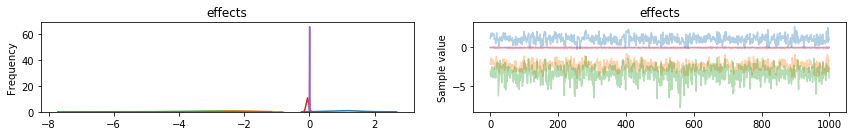

In [21]:
pm.traceplot(trace)

In [22]:
new_y = test['diag']


In [23]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [24]:
new_patientid = test['patientid']


In [25]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [26]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of bacterial by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
np.add(eta, np.dot(new_x, row.transpose())).shape

(361,)

In [27]:
p = invlogit(eta) #probability of malaria infection

p[:20]

array([0.71567077, 0.7492008 , 0.76777901, 0.76304346, 0.75971938,
       0.7628199 , 0.02620978, 0.05530315, 0.79795961, 0.05841396,
       0.05502822, 0.02458243, 0.7611307 , 0.05585691, 0.82462336,
       0.02114376, 0.02114376, 0.05698011, 0.07298352, 0.02707101])

In [28]:
prediction = pd.DataFrame({'p_mal':p}) #build df to visualize results
prediction['pred_mal'] = (prediction['p_mal'] > .5) * 1

In [29]:
prediction["diag"] = new_y.reset_index(drop=True)
prediction["CMalaria"] = new_x.reset_index(drop=True)["CMalaria"]
prediction["Enceph"] = new_x.reset_index(drop=True)["Enceph"]
prediction["Mening"] = new_x.reset_index(drop=True)["Mening"]
prediction["glasgtot"] = new_x.reset_index(drop=True)["glasgtot"]
prediction["sbp"] = new_x.reset_index(drop=True)["sbp"]
prediction["patientid"] = new_patientid.reset_index(drop=True)
prediction.head(5) #observe pred_diag compared to diag to see difference between prediction and actual diagnosis

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid
0,0.715671,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0
1,0.749201,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0
2,0.767779,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0
3,0.763043,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0
4,0.759719,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0


In [380]:
#Now do bact

In [30]:
y = test['diag'].copy()
y[y==2] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 0

In [31]:
x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [32]:
patientid = test['patientid']
patientid = patientid[y.index]

In [33]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [34]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [35]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:18<00:00, 166.32it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [36]:
new_y = test['diag']

In [37]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [38]:
new_patientid = test['patientid']

In [39]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [40]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-3.54764174, -3.55755063, -3.59792093, -3.5388945 , -3.87133894,
       -3.72282465, -2.51897941, -0.70329017, -3.43570495, -0.83314833,
       -0.69148488, -2.74517627, -3.51528392, -0.72690074, -4.57280533,
       -2.58675309, -2.58675309, -0.77412189, -0.4329302 , -3.15340688])

In [41]:
p = invlogit(eta) #probability of bacterial infection

p[:20]

array([0.02798666, 0.02771836, 0.02665087, 0.02822559, 0.02040541,
       0.02359541, 0.07453832, 0.33108316, 0.03119804, 0.30297979,
       0.33370284, 0.06035966, 0.02888047, 0.32587521, 0.01022335,
       0.06999585, 0.06999585, 0.31558813, 0.39342684, 0.04095725])

In [42]:
prediction['p_bact'] = p
prediction['pred_bact'] = (prediction['p_bact'] > .5) * 1
prediction.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact
0,0.715671,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.027987,0
1,0.749201,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027718,0
2,0.767779,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.026651,0
3,0.763043,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.028226,0
4,0.759719,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.020405,0


In [407]:
# Now do vir

In [43]:
y = test['diag'].copy()
y[y==1] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 0
y[y==2] = 1

In [44]:
x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [45]:
patientid = test['patientid']
patientid = patientid[y.index]

In [46]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [47]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [48]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:16<00:00, 184.38it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [49]:
new_y = test['diag']

In [50]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [51]:
new_patientid = test['patientid']

In [52]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [53]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-5.46634408, -5.26264582, -5.19416126, -5.13855364, -5.66477613,
       -5.41834717, -4.60093393, -4.30928671, -4.72179099, -4.43162349,
       -4.29816518, -5.0270627 , -5.11631059, -4.33152976, -6.21909699,
       -4.984332  , -4.984332  , -4.37601586, -3.52200292, -5.51816521])

In [54]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([0.00420887, 0.00515487, 0.00551825, 0.00583196, 0.00345395,
       0.00441489, 0.0099426 , 0.01326481, 0.00882073, 0.01175533,
       0.01341117, 0.00651532, 0.00596235, 0.01297681, 0.00198709,
       0.00679782, 0.00679782, 0.01241919, 0.02869262, 0.00399716])

In [55]:
prediction['p_vir'] = p
prediction['pred_vir'] = (prediction['p_vir'] > .5) * 1
prediction.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir
0,0.715671,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.027987,0,0.004209,0
1,0.749201,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027718,0,0.005155,0
2,0.767779,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.026651,0,0.005518,0
3,0.763043,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.028226,0,0.005832,0
4,0.759719,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.020405,0,0.003454,0


In [56]:
#do mal&bact

In [57]:
y = test['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==4] = 0
y[y==5] = 0
y[y==3] = 1

In [58]:
x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [59]:
patientid = test['patientid']
patientid = patientid[y.index]

In [60]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [61]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [65]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:15<00:00, 189.78it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [66]:
new_y = test['diag']

In [67]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [68]:
new_patientid = test['patientid']

In [69]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [70]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([ -3.6363207 ,  -3.54848379,  -3.54108906,  -3.48021618,
        -3.92111578,  -3.71892784, -11.57296237, -13.24932592,
        -3.22671506, -13.38324625, -13.23715134, -11.9042908 ,
        -3.45586703, -13.27367507,  -4.59549728, -11.78993977,
       -11.78993977, -13.32237337, -12.72536925, -12.37431939])

In [71]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([2.56726604e-02, 2.79637577e-02, 2.81654628e-02, 2.98804127e-02,
       1.94338107e-02, 2.36853585e-02, 9.41720906e-06, 1.76153023e-06,
       3.81726727e-02, 1.54073992e-06, 1.78310715e-06, 6.76128527e-06,
       3.05943729e-02, 1.71915651e-06, 9.99626415e-03, 7.58037907e-06,
       7.58037907e-06, 1.63744246e-06, 2.97468554e-06, 4.22570850e-06])

In [72]:
prediction['p_mal&bact'] = p
prediction['pred_mal&bact'] = (prediction['p_mal&bact'] > .5) * 1
prediction.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact
0,0.715671,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.027987,0,0.004209,0,0.025673,0
1,0.749201,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027718,0,0.005155,0,0.027964,0
2,0.767779,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.026651,0,0.005518,0,0.028165,0
3,0.763043,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.028226,0,0.005832,0,0.029880,0
4,0.759719,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.020405,0,0.003454,0,0.019434,0


In [455]:
#now do tbcrypto

In [73]:
y = test['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==3] = 0
y[y==5] = 0
y[y==4] = 1

In [74]:
x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [75]:
patientid = test['patientid']
patientid = patientid[y.index]

In [76]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [77]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [78]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:17<00:00, 172.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [79]:
new_y = test['diag']

In [80]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [81]:
new_patientid = test['patientid']

In [82]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [83]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-12.65822224, -12.22814528, -12.0277574 , -12.00333973,
       -12.57503916, -12.29651475, -12.01041007,  -4.61548337,
       -11.30938897,  -4.66920223,  -4.61059983, -12.53815769,
       -11.99357267,  -4.62525043, -12.64812914, -12.68971024,
       -12.68971024,  -4.64478457,  -3.41820264, -12.92411984])

In [84]:
p = invlogit(eta) #probability of viral infection

p[:20]

array([3.18128480e-06, 4.89082200e-06, 5.97597450e-06, 6.12368904e-06,
       3.45723088e-06, 4.56761526e-06, 6.08054546e-06, 9.80039971e-03,
       1.22571487e-05, 9.29258725e-03, 9.84790486e-03, 3.58711866e-06,
       6.18379219e-06, 9.70606905e-03, 3.21355628e-06, 3.08267349e-06,
       3.08267349e-06, 9.52009672e-03, 3.17314048e-02, 2.43851265e-06])

In [85]:
prediction['p_tbcrypto'] = p
prediction['pred_tbcrypto'] = (prediction['p_tbcrypto'] > .5) * 1
prediction.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact,p_tbcrypto,pred_tbcrypto
0,0.715671,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.027987,0,0.004209,0,0.025673,0,0.000003,0
1,0.749201,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027718,0,0.005155,0,0.027964,0,0.000005,0
2,0.767779,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.026651,0,0.005518,0,0.028165,0,0.000006,0
3,0.763043,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.028226,0,0.005832,0,0.029880,0,0.000006,0
4,0.759719,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.020405,0,0.003454,0,0.019434,0,0.000003,0


In [483]:
#Now do Other

In [86]:
y = test['diag'].copy()
y[y==1] = 0
y[y==2] = 0
y[y==3] = 0
y[y==4] = 0
y[y==5] = 1

In [87]:
x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]
x = x.loc[y.index]

In [88]:
patientid = test['patientid']
patientid = patientid[y.index]

In [89]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [90]:
with pm.Model() as logistic_model:

    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = tinvlogit(t.sum(effects * x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)



In [92]:
with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)
    
#with logistic_model:
#    # move the chain to the MAP which should be a good starting point
#    start = pm.find_MAP()
#    step = pm.NUTS(scaling=start)
#    trace = pm.sample(5000, step, start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects]
100%|██████████| 3000/3000 [00:15<00:00, 189.46it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [93]:
new_y = test['diag']

In [94]:
new_x = test[['CMalaria','Mening','Enceph','glasgtot','sbp']]

In [95]:
new_patientid = test['patientid']

In [96]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [97]:
eta = np.zeros(new_x.shape[0]) #Generate log odds of viral by averaging posterior
for row in trace['effects'][:,None,:]:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['effects'][:,None,:].shape[0])
eta[:20]

array([-1.19975938, -1.3764945 , -1.50036828, -1.44119126, -1.60768288,
       -1.54219017,  1.99736349,  0.27326454, -1.58793989,  0.14307509,
        0.28509995,  1.93739052, -1.41752045,  0.24959373, -2.39433933,
        2.17961834,  2.17961834,  0.20225211,  0.12731186,  1.61151891])

In [98]:
p = invlogit(eta)

p[:20]

array([0.23151802, 0.20157259, 0.1823706 , 0.19136094, 0.16691056,
       0.17621711, 0.88051998, 0.56789417, 0.16967394, 0.53570788,
       0.5707961 , 0.87406518, 0.19505059, 0.5620765 , 0.08360537,
       0.89840424, 0.89840424, 0.55039137, 0.53178504, 0.83362216])

In [99]:
prediction['p_other'] = p
prediction['pred_other'] = (prediction['p_other'] > .5) * 1
prediction.head(5)

,p_mal,pred_mal,diag,CMalaria,Enceph,Mening,glasgtot,sbp,patientid,p_bact,pred_bact,p_vir,pred_vir,p_mal&bact,pred_mal&bact,p_tbcrypto,pred_tbcrypto,p_other,pred_other
0,0.715671,1,0.0,1.0,0.0,0.0,9.0,86.0,244.0,0.027987,0,0.004209,0,0.025673,0,0.000003,0,0.231518,0
1,0.749201,1,0.0,1.0,0.0,0.0,7.0,94.0,100.0,0.027718,0,0.005155,0,0.027964,0,0.000005,0,0.201573,0
2,0.767779,1,5.0,1.0,0.0,0.0,6.0,101.0,66.0,0.026651,0,0.005518,0,0.028165,0,0.000006,0,0.182371,0
3,0.763043,1,0.0,1.0,0.0,0.0,6.0,96.0,432.0,0.028226,0,0.005832,0,0.029880,0,0.000006,0,0.191361,0
4,0.759719,1,0.0,1.0,0.0,0.0,8.0,117.0,127.0,0.020405,0,0.003454,0,0.019434,0,0.000003,0,0.166911,0


In [100]:
noref_results = prediction

In [101]:
noref_results['patientid'].unique().shape == noref_results['patientid'].shape #patients are all unique

True

In [248]:
#Make final prediction of the logistic regression

In [102]:
noref_results['norefpred'] = 0
noref_results['p_max'] = noref_results['p_bact']
noref_results['p_max'][noref_results['p_vir'] > noref_results['p_max']] = noref_results['p_vir']
noref_results['p_max'][noref_results['p_mal&bact'] > noref_results['p_max']] = noref_results['p_mal&bact']
noref_results['p_max'][noref_results['p_tbcrypto'] > noref_results['p_max']] = noref_results['p_tbcrypto']
noref_results['p_max'][noref_results['p_other'] > noref_results['p_max']] = noref_results['p_other']
noref_results['p_max'][noref_results['p_mal'] > noref_results['p_max']] = noref_results['p_mal']

noref_results['norefpred'][noref_results['p_max'] == noref_results['p_bact']] = 1
noref_results['norefpred'][noref_results['p_max'] == noref_results['p_vir']] = 2
noref_results['norefpred'][noref_results['p_max'] == noref_results['p_mal&bact']] = 3
noref_results['norefpred'][noref_results['p_max'] == noref_results['p_tbcrypto']] = 4
noref_results['norefpred'][noref_results['p_max'] == noref_results['p_other']] = 5
noref_results['norefpred'][noref_results['p_max'] == noref_results['p_mal']] = 0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages

In [103]:
noref_results.to_csv("Outputs/nosplit_results.csv")